# Practica 4 (De nou)

## Requeriments

In [7]:
import gensim
from gensim.models import Word2Vec, word2vec
from gensim.models.word2vec import PathLineSentences
from typing import Tuple, List, Optional
import os
import re

## Codi per entrenar models word2vec

In [2]:
from datasets import load_dataset

dataset = load_dataset("projecte-aina/catalan_general_crawling")
dataset = dataset['train']

c:\Users\Usuario\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Usuario\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for projecte-aina/catalan_general_crawling contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/projecte-aina/catalan_general_crawling
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [29]:
# Getting the first 100 MB of the dataset
size = 0
for i in range(len(dataset)):
    size += len(dataset[i]['text'])
    if size > 100000000:  # 100 MB
        print('files per 100MB:', i)
        break

dataset_100MB = dataset.select(list(range(i)))


# Getting the first 500 MB of the dataset
size = 0
for j in range(len(dataset)):
    size += len(dataset[j]['text'])  # corrected from dataset[i]['text']
    if size > 500000000:  # 500 MB
        print('files per 500MB:', j)
        break

dataset_500MB = dataset.select(list(range(j)))

# Getting the first 1 GB of the dataset
size = 0
for g in range(len(dataset)):
    size += len(dataset[g]['text'])  # corrected from dataset[i]['text']
    if size > 1000000000:  # 1 GB
        print('files per 1GB:', g)
        break

dataset_1GB = dataset.select(list(range(g)))

# Getting the whole dataset
dataset_complet = dataset

files per 100MB: 57333
files per 500MB: 213432
files per 1GB: 410702


In [30]:
datasets = {}
datasets['100MB'] = dataset_100MB
datasets['500MB'] = dataset_500MB
datasets['1GB'] = dataset_1GB  
datasets['complet'] = dataset_complet

models = {}

In [31]:
stopwords_catala = [ 
    "a", "abans", "ací", "així", "alguns", "alguna", "algunes", "algú", "alhora", 
    "als", "allò", "aquell", "aquelles", "aquell", "aquells", "baix", 
    "cada", "com", "com a", "eixa", "eixes", "eixí", 
    "eixos", "el", "ella", "elles", "ell", "ells", "en", "endavant", "enfront", 
    "ens", "entre", "he", "hem", "heu", "hi", "ho", 
    "i", "igual", "iguals", "ja", "jo", "l'", "la", "les", "li", "els", "tu", "nosaltres", "vosaltres",
    "de", "del", "dels", "d'un", "d'una", "d'uns", "d'unes", "des", "des de",
    ]

# Funció per netejar i tokenitzar el text
def preprocess_text(text):
    # Neteja el text: treu caràcters no desitjats, converteix a minúscules, etc.
    text = re.sub(r'\W+', ' ', text)  # Substitueix caràcters no alfanumèrics per espais
    text = text.lower()  # Converteix a minúscules
    words = text.split()  # Tokenitza
    # elimina stopwords
    words = [word for word in words if word not in stopwords_catala]
    return words

# Carrega el fitxer de text i processa'l
def create_corpus(dataset):
    corpus = []
    for line in dataset:
        words = preprocess_text(line['text'])
        if words:  # Assegura't que la línia no està buida
            corpus.append(words)
    return corpus

corpus_dict = {}
for mida in ["100MB", "500MB", "1GB", "complet"]:
    dataset = datasets[mida]
    corpus_dict[f"corpus_{mida}"] = create_corpus(dataset=dataset)
    print(f"Corpus {mida} creat")


Corpus 100MB creat
Corpus 500MB creat
Corpus 1GB creat
Corpus complet creat


In [95]:
def entrenar_word2vec(corpus, mida_vector=100, finestra=5, sg=1, min_count=10, workers=4, epochs=25):
    
    model = word2vec.Word2Vec(corpus, vector_size=mida_vector, window=finestra, min_count=min_count, workers=workers, epochs=epochs, sg=sg)
    
    return model

# Entrenar models per a cada mida de dataset
for mida in ["500MB", "1GB", "complet"]: # "100MB"
    corpus = corpus_dict[f"corpus_{mida}"]
    model = entrenar_word2vec(corpus)
    models[mida] = model
    model.save(f"model_{mida}.model")


In [8]:
for model in ['100MB', '500MB', '1GB', 'complet']:
    # load model
    models[model] = gensim.models.Word2Vec.load(f"model_{model}.model")
    
models['100MB'] = gensim.models.Word2Vec.load("model_100MB.model")

## Model de Similitud de Text Semàntic

In [9]:
# Requisites
from gensim.models import TfidfModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
from scipy import spatial
from typing import Tuple, List

In [10]:
from datasets import load_dataset

text_semantic = load_dataset("projecte-aina/sts-ca")

c:\Users\Usuario\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for projecte-aina/sts-ca contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/projecte-aina/sts-ca
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [8]:
text_semantic['train']['sentence1'][0]

'Atorga per primer cop les mencions Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència Universitària'

### Inicialització

In [11]:
input_pairs = [(e["sentence1"], e["sentence2"], e["label"], ) for e in text_semantic["train"].to_list()]
input_pairs_val = [(e["sentence1"], e["sentence2"], e["label"], ) for e in text_semantic["validation"].to_list()]
input_pairs_test = [(e["sentence1"], e["sentence2"], e["label"], ) for e in text_semantic["test"].to_list()]

#### Train

In [12]:
# Suposem que tens els teus texts i labels
texts = [(sentence1, sentence2) for sentence1, sentence2, _ in input_pairs]
labels = [label for _, _, label in input_pairs]

In [13]:
from collections import defaultdict

# Tokenitzar i preparar les seqüències d'entrada per als models
def tokenitzar(text):
    return text.lower().split()

def construir_diccionari(texts):
    word_to_index = defaultdict(lambda: len(word_to_index))
    for text in texts:
        tokens = tokenitzar(text)
        for token in tokens:
            word_to_index[token]
    return dict(word_to_index)

# Obtenim tots els textos del dataset
all_texts = [text for pair in input_pairs for text in pair[:2]]
word_to_index = construir_diccionari(all_texts)

In [14]:
def text_to_sequence(text, word_to_index):
    tokens = tokenitzar(text)
    return [word_to_index[token] for token in tokens]

# Convertir tots els textos a seqüències d'índexs
input_sequences = [(text_to_sequence(pair[0], word_to_index), text_to_sequence(pair[1], word_to_index)) for pair in input_pairs]

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max length of the sequences
max_len = max(max(len(seq[0]), len(seq[1])) for seq in input_sequences) 

# Padding de les seqüències d'índexs
input_1_sequences = pad_sequences([seq[0] for seq in input_sequences], maxlen=max_len, padding='post')
input_2_sequences = pad_sequences([seq[1] for seq in input_sequences], maxlen=max_len, padding='post')

In [16]:
input_1_sequences.shape, input_2_sequences.shape

((2073, 37), (2073, 37))

In [17]:
# Convertir les seqüències i labels a arrays numpy
input_1_sequences = np.array(input_1_sequences)
input_2_sequences = np.array(input_2_sequences)
labels = np.array(labels)

# Ajustar la mida del diccionari basat en el nombre de paraules úniques
dictionary_size = len(word_to_index)

#### Test

In [18]:
texts_test = [(sentence1, sentence2) for sentence1, sentence2, _ in input_pairs_test]
labels_test = [label for _, _, label in input_pairs_test]

In [19]:
# Obtenim tots els textos del dataset
all_texts_test = [text for pair in input_pairs_test for text in pair[:2]]
word_to_index_test = construir_diccionari(all_texts_test)

# Convertir tots els textos a seqüències d'índexs
input_sequences_test = [(text_to_sequence(pair[0], word_to_index_test), text_to_sequence(pair[1], word_to_index_test)) for pair in input_pairs_test]

# max length of the sequences
max_len_test = max(max(len(seq[0]), len(seq[1])) for seq in input_sequences_test) 

# Padding de les seqüències d'índexs
input_1_sequences_test = pad_sequences([seq[0] for seq in input_sequences_test], maxlen=max_len, padding='post')
input_2_sequences_test = pad_sequences([seq[1] for seq in input_sequences_test], maxlen=max_len, padding='post')

In [20]:
input_1_sequences_test.shape, input_2_sequences_test.shape

((500, 37), (500, 37))

In [21]:
# Convertir les seqüències i labels a arrays numpy
input_1_sequences_test = np.array(input_1_sequences_test)
input_2_sequences_test= np.array(input_2_sequences_test)
labels_test = np.array(labels_test)

#### Validation

In [22]:
# Suposem que tens els teus texts i labels
texts_val = [(sentence1, sentence2) for sentence1, sentence2, _ in input_pairs_val]
labels_val = [label for _, _, label in input_pairs_val]

# Obtenim tots els textos del dataset
all_texts_val = [text for pair in input_pairs_val for text in pair[:2]]
word_to_index_val = construir_diccionari(all_texts_val)

# Convertir tots els textos a seqüències d'índexs
input_sequences_val = [(text_to_sequence(pair[0], word_to_index_val), text_to_sequence(pair[1], word_to_index_val)) for pair in input_pairs_val]

# max length of the sequences
max_len_val = max(max(len(seq[0]), len(seq[1])) for seq in input_sequences_val) 

# Padding de les seqüències d'índexs
input_1_sequences_val = pad_sequences([seq[0] for seq in input_sequences_val], maxlen=max_len, padding='post')
input_2_sequences_val = pad_sequences([seq[1] for seq in input_sequences_val], maxlen=max_len, padding='post')

In [23]:
input_1_sequences_test.shape, input_2_sequences_test.shape

((500, 37), (500, 37))

In [24]:
# Convertir les seqüències i labels a arrays numpy
input_1_sequences_val = np.array(input_1_sequences_val)
input_2_sequences_val= np.array(input_2_sequences_val)
labels_val = np.array(labels_val)

#### Datasets

In [25]:
import tensorflow as tf
import numpy as np

batch_size = 64

# Crear Dataset de TensorFlow per a les dades d'entrenament
train_dataset = tf.data.Dataset.from_tensor_slices(((input_1_sequences, input_2_sequences), labels))
train_dataset = train_dataset.shuffle(buffer_size=len(labels)).batch(batch_size)

# Crear Dataset de TensorFlow per a les dades de validació
val_dataset = tf.data.Dataset.from_tensor_slices(((input_1_sequences_val, input_2_sequences_val), labels_val))
val_dataset = val_dataset.batch(batch_size)

# Crear Dataset de TensorFlow per a les dades de test
test_dataset = tf.data.Dataset.from_tensor_slices(((input_1_sequences_test, input_2_sequences_test), labels_test))
test_dataset = test_dataset.batch(batch_size)
 

## Model Baseline

In [ ]:
import tensorflow as tf

def model_2(
    input_length: int = 37,
    dictionary_size: int = 1000,
    embedding_size: int = 100,
    learning_rate: float = 0.01,
    pretrained_weights: Optional[np.ndarray] = None,
    trainable: bool = False,
    use_cosine: bool = False,
    l2_regularizer: float = 1e-4,
) -> tf.keras.Model:
    # Inputs
    input_1 = tf.keras.Input((input_length,), dtype=tf.int32)
    input_2 = tf.keras.Input((input_length,), dtype=tf.int32)

    # Embedding Layer
    if pretrained_weights is None:
        embedding = tf.keras.layers.Embedding(
            dictionary_size, embedding_size, input_length=input_length, mask_zero=True, embeddings_initializer='uniform'
        )
    else:
        # Obtener la matriz de embeddings del modelo Word2Vec
        word_vectors = pretrained_weights.wv
        embedding_matrix = np.zeros((len(word_vectors), embedding_size))
        for i in range(len(word_vectors)):
            embedding_matrix[i] = word_vectors[word_vectors.index_to_key[i]]
            
        dictionary_size = embedding_matrix.shape[0]
        embedding_size = embedding_matrix.shape[1]
        initializer = tf.keras.initializers.Constant(embedding_matrix)
        embedding = tf.keras.layers.Embedding(
            dictionary_size,
            embedding_size,
            input_length=input_length,
            mask_zero=True,
            embeddings_initializer=initializer,
            trainable=trainable,
        )

    # Embed the inputs
    embedded_1 = embedding(input_1)
    embedded_2 = embedding(input_2)
    # Pass through the embedding layer
    _input_mask_1, _input_mask_2 = tf.not_equal(input_1, 0), tf.not_equal(input_2, 0)
    
    # Attention Mechanism
    attention_mlp = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    # Apply attention to each embedding
    attention_weights_1 = attention_mlp(embedded_1)  
    attention_weights_2 = attention_mlp(embedded_2) 
    # Mask the attention weights
    attention_weights_1 = tf.exp(attention_weights_1) * tf.cast(_input_mask_1[:, :, None], tf.float32)
    attention_weights_2 = tf.exp(attention_weights_2) * tf.cast(_input_mask_2[:, :, None], tf.float32)
    # Normalize attention weights
    attention_weights_1 = attention_weights_1 / tf.reduce_sum(attention_weights_1, axis=1, keepdims=True)
    attention_weights_2 = attention_weights_2 / tf.reduce_sum(attention_weights_2, axis=1, keepdims=True)
    # Compute context vectors
    projected_1 = tf.reduce_sum(embedded_1 * attention_weights_1, axis=1) 
    projected_2 = tf.reduce_sum(embedded_2 * attention_weights_2, axis=1) 
    
    if use_cosine:
        # Compute the cosine distance using a Lambda layer
        def cosine_distance(x):
            x1, x2 = x
            x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
            x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
            return 2.5 * (1.0 + tf.reduce_sum(x1_normalized * x2_normalized, axis=1))
        output = tf.keras.layers.Lambda(cosine_distance)([projected_1, projected_2])
    else:
         # Compute the cosine distance using a Lambda layer
        def normalized_product(x):
            x1, x2 = x
            x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
            x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
            return x1_normalized * x2_normalized
    
        output = tf.keras.layers.Lambda(normalized_product)([projected_1, projected_2])
        output = tf.keras.layers.Dropout(0.1)(output)
        output = tf.keras.layers.Dense(
            16,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
        )(output)
        output = tf.keras.layers.Dropout(0.2)(output)
        output = tf.keras.layers.Dense(
            1,
            activation="sigmoid",
        )(output)
        
        output = tf.keras.layers.Lambda(lambda x: x * 5)(output)
        
    # Model Definition
    model = tf.keras.Model(inputs=(input_1, input_2), outputs=output)
    model.compile(
        loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    )
    return model

## Diferents models de Word Embeddings

### One Hot

In [ ]:
# Preprcessament del text_semantic
corpus_semantic = []
semantic_score = []
for line in text_semantic['train']:
    frase1 = preprocess_text(line['sentence1'])
    frase2 = preprocess_text(line['sentence2'])

    corpus_semantic.append((frase1, frase2))
    semantic_score.append(line['label'])

In [ ]:
corpus_semantic_test = []
semantic_score_test = []
for line in text_semantic['test']:
    frase1 = preprocess_text(line['sentence1'])
    frase2 = preprocess_text(line['sentence2'])

    corpus_semantic_test.append((frase1, frase2))
    semantic_score_test.append(line['label'])

In [ ]:
vocabulari = {}

for frases in corpus_semantic:
    for frase in frases:
        for paraula in frase:
            if paraula in vocabulari:
                vocabulari[paraula] += 1
            else:
                vocabulari[paraula] = 1

In [ ]:
vocabulari_reduit = {palabra for palabra, frecuencia in vocabulari.items() if frecuencia >= 10}

In [ ]:
import numpy as np

# Función para calcular la representación one-hot de un texto
def compute_one_hot_encoding(text, vocabulari):
    """
    Genera la representación one-hot de un texto utilizando un vocabulario predefinido.
    """
    one_hot_vector = np.zeros(len(vocabulari))
    vocabulario_list = list(vocabulari)
    for palabra in text:
        if palabra in vocabulari:
            index = vocabulario_list.index(palabra)
            one_hot_vector[index] = 1
        
    return one_hot_vector

In [ ]:
# Passar les frases de corpus_semantic a vectors
one_hot_corpus_semantic = corpus_semantic.copy()
for i, (frase1, frase2) in enumerate(one_hot_corpus_semantic):
    one_hot_corpus_semantic[i] = (compute_one_hot_encoding(frase1, vocabulari_reduit), 
                                    compute_one_hot_encoding(frase2, vocabulari_reduit))

In [ ]:
#### Entrenament de la xarxa amb els vectors de les frases ####

# Convertir les llistes de tuples a arrays de NumPy
vectors_1 = np.array([pair[0] for pair in one_hot_corpus_semantic])
vectors_2 = np.array([pair[1] for pair in one_hot_corpus_semantic])

# Comprovar si hi ha valors fora de rang i substituir-los
vectors_1 = np.clip(vectors_1, 0, 1)
vectors_2 = np.clip(vectors_2, 0, 1)

# Convertir les llistes de similituds a un array de NumPy
semantic_score = np.array(semantic_score)

baseline_model.fit(
    [vectors_1, vectors_2], 
    semantic_score, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2
)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Pasar las frases de corpus_semantic a vectores
one_hot_corpus_semantic_test = corpus_semantic_test.copy()
for i, (frase1, frase2) in enumerate(one_hot_corpus_semantic_test):
    one_hot_corpus_semantic_test[i] = (compute_one_hot_encoding(frase1, vocabulari_reduit), 
                                    compute_one_hot_encoding(frase2, vocabulari_reduit))

vectors_1 = np.array([pair[0] for pair in one_hot_corpus_semantic_test])
vectors_2 = np.array([pair[1] for pair in one_hot_corpus_semantic_test])

# Obtener predicciones del modelo
predicciones = baseline_model.predict([vectors_1, vectors_2])

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(semantic_score_test, predicciones)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(semantic_score_test, predicciones)

# Mostrar las predicciones, el MSE y el R^2
#print("Predicciones:", predicciones)
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

### Model Word2Vec

Realitzem el model de regressio amb els embeddings dels models Word2Vec + Mean i + Mean Ponderada.

In [ ]:
all_input_pairs = input_pairs + input_pairs_val + input_pairs_test
# Preprocesamiento de las oraciones y creación del diccionario
sentences_1_preproc = [simple_preprocess(sentence_1) for sentence_1, _, _ in all_input_pairs]
sentences_2_preproc = [simple_preprocess(sentence_2) for _, sentence_2, _ in all_input_pairs]
sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc))
# Versión aplanada para poder entrenar el modelo
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc
diccionario = Dictionary(sentences_pairs_flattened)

In [ ]:
# Cálculo de los pesos TF-IDF para las oraciones pre-procesadas
corpus = [diccionario.doc2bow(sent) for sent in sentences_pairs_flattened]
modelo_tfidf = TfidfModel(corpus)

In [ ]:
def map_tf_idf(sentence_preproc: List[str], dictionary: Dictionary, tf_idf_model: TfidfModel, wv_model) -> Tuple[List[np.ndarray], List[float]]:
    bow = dictionary.doc2bow(sentence_preproc)
    tf_idf = tf_idf_model[bow]
    vectors, weights = [], []
    for word_index, weight in tf_idf:
        word = dictionary.get(word_index)
        if word in wv_model:
            vectors.append(wv_model[word])
            weights.append(weight)
    return vectors, weights

def map_pairs(
        sentence_pairs: List[Tuple[str, str, float]],
        dictionary: Dictionary = None,
        tf_idf_model: TfidfModel = None,
        wv_model: gensim.models.word2vec.Word2VecKeyedVectors = None,
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        sentence_1_preproc = preprocess_text(sentence_1)
        sentence_2_preproc = preprocess_text(sentence_2)
        # Si usamos TF-IDF
        if tf_idf_model is not None:
            # Cálculo del promedio ponderado por TF-IDF de los word embeddings
            vectors1, weights1 = map_tf_idf(sentence_1_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model, wv_model=wv_model,)
            vectors2, weights2 = map_tf_idf(sentence_2_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model, wv_model=wv_model,)
            vector1 = np.average(vectors1, weights=weights1, axis=0, )
            vector2 = np.average(vectors2, weights=weights2, axis=0, )
        else:
            # Cálculo del promedio de los word embeddings
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vectors2 = [wv_model[word] for word in sentence_2_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)
        # Añadir a la lista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

def pair_list_to_x_y(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], int]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    _x, _y = zip(*pair_list)
    _x_1, _x_2 = zip(*_x)
    return (np.array(_x_1), np.array(_x_2)), np.array(_y, dtype=np.float32, )

#### Word2Vec + Mean

In [ ]:
def prepare_datasets(model: gensim.models.word2vec.Word2VecKeyedVectors, batch_size: int = 64):
    
    # Imprimir los pares de vectores y la puntuación de similitud asociada
    mapped_train = map_pairs(input_pairs,  dictionary=diccionario, wv_model = model)
    mapped_val = map_pairs(input_pairs_val, dictionary=diccionario, wv_model = model)
    mapped_test = map_pairs(input_pairs_test, dictionary=diccionario, wv_model = model)

    # Obtener las listas de train y test
    x_train, y_train = pair_list_to_x_y(mapped_train)
    x_val, y_val = pair_list_to_x_y(mapped_val)
    x_test, y_test = pair_list_to_x_y(mapped_test)

    # Preparar los conjuntos de datos de entrenamiento y validación
    train_dataset_ = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset_ = train_dataset_.shuffle(buffer_size=len(x_train)).batch(batch_size)

    val_dataset_ = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset_ = val_dataset_.batch(batch_size)
    

    # Construir y compilar el modelo
    embedding_model = build_and_compile_model()
    
    # Train the model
    embedding_model.fit(train_dataset_, epochs=64, validation_data=val_dataset_)

    # Prediccions del test
    prediccions_word2vec = embedding_model.predict(x_test)

    # MSE
    mse_word2vec = mean_squared_error(y_test, prediccions_word2vec)

    print(f"MSE del model amb Word2Vec Embeddings: {mse_word2vec}")
    print(f"R^2 del model amb Word2Vec Embeddings: {r2_score(y_test, prediccions_word2vec)}")
    
    

for mida in ["500MB", "1GB", "complet"]:
    model = models[mida]
    datasets = prepare_datasets(model)
    print(f"Datasets preparados para el modelo {mida}")

#### Word2Vec + Mean Ponderada

In [ ]:
def prepare_datasets_mean_ponderada(model: gensim.models.word2vec.Word2VecKeyedVectors, batch_size: int = 64):
    
    # Imprimir los pares de vectores y la puntuación de similitud asociada
    mapped_train = map_pairs(input_pairs,  tf_idf_model=modelo_tfidf, dictionary=diccionario, wv_model = model)
    mapped_val = map_pairs(input_pairs_val, tf_idf_model=modelo_tfidf, dictionary=diccionario, wv_model = model)
    mapped_test = map_pairs(input_pairs_test, tf_idf_model=modelo_tfidf, dictionary=diccionario, wv_model = model)

    # Obtener las listas de train y test
    x_train, y_train = pair_list_to_x_y(mapped_train)
    x_val, y_val = pair_list_to_x_y(mapped_val)
    x_test, y_test = pair_list_to_x_y(mapped_test)

    # Preparar los conjuntos de datos de entrenamiento y validación
    train_dataset_ = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset_ = train_dataset_.shuffle(buffer_size=len(x_train)).batch(batch_size)

    val_dataset_ = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset_ = val_dataset_.batch(batch_size)
    
    
    # Construir y compilar el modelo
    embedding_model = build_and_compile_model()
    
    # Train the model
    embedding_model.fit(train_dataset_, epochs=64, validation_data=val_dataset_)

    # Prediccions del test
    prediccions_word2vec = embedding_model.predict(x_test)

    # MSE
    mse_word2vec = mean_squared_error(y_test, prediccions_word2vec)

    print(f"MSE del model amb Word2Vec Embeddings: {mse_word2vec}")
    print(f"R^2 del model amb Word2Vec Embeddings: {r2_score(y_test, prediccions_word2vec)}")
    
    

for mida in ["500MB", "1GB", "complet"]:
    model = models[mida]
    datasets = prepare_datasets_mean_ponderada(model)
    print(f"Datasets preparados para el modelo {mida}")

#### Word2Vec + Mean amb model de Linear Regression

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Exemple de preprocessament de text
def obtenir_vectores_mean(text, model_word2vec):
    tokens = text.split()
    vectors = [model_word2vec.wv[word] for word in tokens if word in model_word2vec.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model_word2vec.vector_size)

# Exemple d'entrenament del model de regressió
def entrenar_model_regressio(texts, labels, model_word2vec):
    X = np.array([np.concatenate((obtenir_vectores_mean(text1, model_word2vec), obtenir_vectores_mean(text2, model_word2vec))) 
                  for text1, text2 in texts])
    
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediccions = model.predict(X_test)
    mse = mean_squared_error(y_test, prediccions)
    return model, mse

# Entrenar el model de regressió utilitzant un dels models Word2Vec
texts =  [(sentence1, sentence2) for sentence1, sentence2, _ in input_pairs] # textos del dataset
labels = [label for _, _, label in input_pairs]  # similituds reals
model_word2vec = Word2Vec.load("model_100MB") # utilitzar el model Word2Vec entrenat

model_regressio, mse = entrenar_model_regressio(texts, labels, model_word2vec)
print(f"MSE del model de regressió: {mse}")


MSE del model de regressió: 0.6825629832324949


Un valor d'MSE de 0.6825629832324949 indica que l'error quadràtic mitjà entre les prediccions del model i els valors reals és relativament alt. Això suggereix que el model de regressió no està fent prediccions molt precises.

In [20]:
# Funció per predir la similitud entre dos textos
def predir_similitud(text1, text2, model_regressio, model_word2vec):
    vector1 = obtenir_vectores_mean(text1, model_word2vec)
    vector2 = obtenir_vectores_mean(text2, model_word2vec)
    vector_concat = np.concatenate((vector1, vector2)).reshape(1, -1)
    prediccio = model_regressio.predict(vector_concat)
    return prediccio[0]

# Exemple de predicció
text1 = "Aquest és un text"
text2 = "Aquest és un altre text"
similitud = predir_similitud(text1, text2, model_regressio, model_word2vec)
print(f"Similitud predita: {similitud}")


Similitud predita: 2.6517136096954346


### 3. spaCy

In [ ]:
!py -m spacy download ca_core_news_md

In [ ]:
import spacy

nlp_md = spacy.load('ca_core_news_md')

In [ ]:
def spacy_mean_embedding(text1, text2, model):
    """
    Agafa els vectors d'embeddings de cada paraula en una frase o document i 
    calcula la mitjana dels vectors per obtenir una única representació vectorial 
    per a la frase o document.
    """
    text1 = ' '.join(text1)
    text2 = ' '.join(text2)
    frase1 = model(text1).vector
    frase2 = model(text2).vector
    
    return frase1, frase2

In [ ]:
# Passar les frases de corpus_semantic a vectors
spacy_mean_embbeding_corpus_semantic = corpus_semantic.copy()
for i, (frase1, frase2) in enumerate(spacy_mean_embbeding_corpus_semantic):
    
    frase1, frase2 = spacy_mean_embedding(frase1, frase2, nlp_md)
    spacy_mean_embbeding_corpus_semantic[i] = (frase1, frase2)

In [ ]:
#### Entrenament de la xarxa amb els vectors de les frases ####

# Convertir les llistes de tuples a arrays de NumPy
vectors_1 = np.array([pair[0] for pair in spacy_mean_embbeding_corpus_semantic])
vectors_2 = np.array([pair[1] for pair in spacy_mean_embbeding_corpus_semantic])

# Comprovar si hi ha valors fora de rang i substituir-los
#vectors_1 = np.clip(vectors_1, 0, 999)
#vectors_2 = np.clip(vectors_2, 0, 999)

# Convertir les llistes de similituds a un array de NumPy
semantic_score = np.array(semantic_score)

print(vectors_1.shape)
print(vectors_2.shape)
print(semantic_score.shape)

baseline_model.fit(
    [vectors_1, vectors_2], 
    semantic_score, 
    epochs=50, 
    batch_size=32, 
    

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Pasar las frases de corpus_semantic a vectores
spacy_mean_embbeding_corpus_semantic_test = corpus_semantic_test.copy()
for i, (frase1, frase2) in enumerate(spacy_mean_embbeding_corpus_semantic_test):
    
    frase1, frase2 = spacy_mean_embedding(frase1, frase2, nlp_md)
    spacy_mean_embbeding_corpus_semantic_test[i] = (frase1, frase2)

vectors_1 = np.array([pair[0] for pair in spacy_mean_embbeding_corpus_semantic_test])
vectors_2 = np.array([pair[1] for pair in spacy_mean_embbeding_corpus_semantic_test])

# Obtener predicciones del modelo
predicciones = baseline_model.predict([vectors_1, vectors_2])

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(semantic_score_test, predicciones)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(semantic_score_test, predicciones)

# Mostrar las predicciones, el MSE y el R^2
#print("Predicciones:", predicciones)
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

### 4.RoBERTa

In [ ]:
!py -m spacy download ca_core_news_trf

In [ ]:
import spacy

nlp_trf = spacy.load('ca_core_news_trf')

In [ ]:
def spacy_trf_CLS(frase1, frase2, model):# Procesar la frase
    frase1 = ' '.join(frase1)
    frase2 = ' '.join(frase2)
    doc1 = model(frase1)
    doc2 = model(frase2)

    # Obtener el embedding CLS
    embedding_CLS1 = doc1._.trf_data.last_hidden_layer_state
    embedding_array1 = embedding_CLS1.data
    embedding_CLS2 = doc2._.trf_data.last_hidden_layer_state
    embedding_array2 = embedding_CLS2.data
    
    return embedding_array1, embedding_array2

In [ ]:
spacy_trf_CLS_corpus_semantic = corpus_semantic.copy()
for i, (frase1, frase2) in enumerate(spacy_trf_CLS_corpus_semantic):
    
    frase1, frase2 = spacy_trf_CLS(frase1, frase2, nlp_trf)
    spacy_trf_CLS_corpus_semantic[i] = (frase1, frase2)

In [ ]:
#### Entrenament de la xarxa amb els vectors de les frases ####

# Convertir les llistes de tuples a arrays de NumPy
vectors_1 = np.array([pair[0][0] for pair in spacy_trf_CLS_corpus_semantic])
vectors_2 = np.array([pair[0][1] for pair in spacy_trf_CLS_corpus_semantic])

# Comprovar si hi ha valors fora de rang i substituir-los
#vectors_1 = np.clip(vectors_1, 0, 999)
#vectors_2 = np.clip(vectors_2, 0, 999)

# Convertir les llistes de similituds a un array de NumPy
semantic_score = np.array(semantic_score)

print(vectors_1.shape)
print(vectors_2.shape)
print(semantic_score.shape)

baseline_model.fit(
    [vectors_1, vectors_2], 
    semantic_score, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2
)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Pasar las frases de corpus_semantic a vectores
spacy_trf_CLS_corpus_semantic_test = corpus_semantic_test.copy()
for i, (frase1, frase2) in enumerate(spacy_trf_CLS_corpus_semantic_test):
    
    frase1, frase2 = spacy_trf_CLS(frase1, frase2, nlp_trf)
    spacy_trf_CLS_corpus_semantic_test[i] = (frase1, frase2)

vectors_1 = np.array([pair[0][0] for pair in spacy_trf_CLS_corpus_semantic_test])
vectors_2 = np.array([pair[0][1] for pair in spacy_trf_CLS_corpus_semantic_test])

# Obtener predicciones del modelo
predicciones = baseline_model.predict([vectors_1, vectors_2])

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(semantic_score_test, predicciones)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(semantic_score_test, predicciones)

# Mostrar las predicciones, el MSE y el R^2
#print("Predicciones:", predicciones)
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

In [ ]:
import spacy
import numpy as np

# Cargar el modelo
nlp_trf = spacy.load('ca_core_news_trf')

# Frase de ejemplo
frase1 = 'atorga per primer cop les mencions encarna sanahuja a la inclusió de la perspectiva de gènere en docència universitària'
doc = nlp_trf(frase1)

# Obtener las representaciones de la última capa oculta
embeddings = doc._.trf_data.last_hidden_layer_state

# Convertir a numpy array
embeddings_np = np.array(embeddings.data)

# Calcular la media de los embeddings a lo largo del eje de las palabras
mean_embedding = np.mean(embeddings_np, axis=1)

print(mean_embedding)

In [ ]:
def spacy_trf_mean(frase1, frase2, model):
    frase1 = ' '.join(frase1)
    frase2 = ' '.join(frase2)
    doc1 = model(frase1)
    doc2 = model(frase2)

    # Obtener el embedding CLS
    embedding_CLS1 = doc1._.trf_data.last_hidden_layer_state
    embedding_array1 = embedding_CLS1.data
    embedding_CLS2 = doc2._.trf_data.last_hidden_layer_state
    embedding_array2 = embedding_CLS2.data
    
    return np.array(embedding_array1.data), np.array(embedding_array2.data)

In [ ]:
spacy_trf_mean_corpus_semantic = corpus_semantic.copy()
for i, (frase1, frase2) in enumerate(spacy_trf_mean_corpus_semantic):
    
    frase1, frase2 = spacy_trf_CLS(frase1, frase2, nlp_trf)
    spacy_trf_mean_corpus_semantic[i] = (frase1, frase2)

In [ ]:
#### Entrenament de la xarxa amb els vectors de les frases ####

# Convertir les llistes de tuples a arrays de NumPy
vectors_1 = np.array([pair[0][0] for pair in spacy_trf_CLS_corpus_semantic])
vectors_2 = np.array([pair[0][1] for pair in spacy_trf_CLS_corpus_semantic])

# Comprovar si hi ha valors fora de rang i substituir-los
#vectors_1 = np.clip(vectors_1, 0, 999)
#vectors_2 = np.clip(vectors_2, 0, 999)

# Convertir les llistes de similituds a un array de NumPy
semantic_score = np.array(semantic_score)

print(vectors_1.shape)
print(vectors_2.shape)
print(semantic_score.shape)

baseline_model.fit(
    [vectors_1, vectors_2], 
    semantic_score, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2
)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Pasar las frases de corpus_semantic a vectores
spacy_trf_mean_corpus_semantic_test = corpus_semantic_test.copy()
for i, (frase1, frase2) in enumerate(spacy_trf_mean_corpus_semantic_test):
    
    frase1, frase2 = spacy_trf_mean(frase1, frase2, nlp_trf)
    spacy_trf_mean_corpus_semantic_test[i] = (frase1, frase2)

vectors_1 = np.array([pair[0][0] for pair in spacy_trf_mean_corpus_semantic_test])
vectors_2 = np.array([pair[0][1] for pair in spacy_trf_mean_corpus_semantic_test])

# Obtener predicciones del modelo
predicciones = baseline_model.predict([vectors_1, vectors_2])

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(semantic_score_test, predicciones)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(semantic_score_test, predicciones)

# Mostrar las predicciones, el MSE y el R^2
#print("Predicciones:", predicciones)
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

### 5. RoBERTa fine-tuned

In [ ]:
from transformers import pipeline, AutoTokenizer
from scipy.special import logit

model = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model)
pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state

In [ ]:
RoBERTa_corpus_semantic = corpus_semantic.copy()
for i, (frase1, frase2) in enumerate(RoBERTa_corpus_semantic):
    frase1 = get_embeddings(frase1)
    frase2 = get_embeddings(frase2)
    RoBERTa_corpus_semantic[i] = (frase1, frase2)

In [ ]:
#### Entrenament de la xarxa amb els vectors de les frases ####

# Convertir les llistes de tuples a arrays de NumPy
vectors_1 = np.array([pair[0][0] for pair in RoBERTa_corpus_semantic])
vectors_2 = np.array([pair[0][1] for pair in RoBERTa_corpus_semantic])

# Comprovar si hi ha valors fora de rang i substituir-los
#vectors_1 = np.clip(vectors_1, 0, 999)
#vectors_2 = np.clip(vectors_2, 0, 999)

# Convertir les llistes de similituds a un array de NumPy
semantic_score = np.array(semantic_score)

print(vectors_1.shape)
print(vectors_2.shape)
print(semantic_score.shape)

baseline_model.fit(
    [vectors_1, vectors_2], 
    semantic_score, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2
)

In [ ]:
def prepare(sentence_pairs):
    sentence_pairs_prep = []
    for s1, s2 in sentence_pairs:
        sentence_pairs_prep.append(f"{tokenizer.cls_token} {s1}{tokenizer.sep_token}{tokenizer.sep_token} {s2}{tokenizer.sep_token}")
    return sentence_pairs_prep

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
model_name = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = AutoModel.from_pretrained(model_name)

# Convert sentence pairs to embeddings using the transformer model
def get_embeddings(sentence_pairs):
    prepared_pairs = prepare(sentence_pairs)
    embeddings = []
    for pair in prepared_pairs:
        inputs = tokenizer(pair, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = transformer_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return embeddings

fine_tuned_corpus_semantic = corpus_semantic.copy()
for i, (frase1, frase2) in enumerate(fine_tuned_corpus_semantic):
    fine_tuned_corpus_semantic[i] = (' '.join(frase1), ' '.join(frase2))

embeddings = get_embeddings(fine_tuned_corpus_semantic)

In [ ]:
fine_runed_corpus_semantic = corpus_semantic.copy()
for i, (frase1, frase2) in enumerate(fine_runed_corpus_semantic):
    frase1 = ' '.join(frase1)
    frase2 = ' '.join(frase2)
    fine_runed_corpus_semantic[i] = (frase1, frase2)

In [ ]:
predictions = pipe(prepare(fine_runed_corpus_semantic), add_special_tokens=False)

# convert back to scores to the original 0 and 5 interval
for prediction in predictions:
    prediction['score'] = logit(prediction['score'])
print(predictions)

In [ ]:
def compute_mean_embedding(text, model, embedding_dim):
    """
    Agafa els vectors d'embeddings de cada paraula en una frase o document i 
    calcula la mitjana dels vectors per obtenir una única representació vectorial 
    per a la frase o document.
    """
    vectors = [model[word] for word in text if word in model]
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros(embedding_dim)
    return mean_vector


from sklearn.metrics import mean_squared_error, r2_score

# Pasar las frases de corpus_semantic a vectores
mean_embbeding_corpus_semantic_test = corpus_semantic_test.copy()
for i, (frase1, frase2) in enumerate(mean_embbeding_corpus_semantic_test):
    mean_embbeding_corpus_semantic_test[i] = (
        compute_mean_embedding(frase1, model_100MB.wv, 100),
        compute_mean_embedding(frase2, model_100MB.wv, 100)
    )

vectors_1 = np.array([pair[0] for pair in mean_embbeding_corpus_semantic_test])
vectors_2 = np.array([pair[1] for pair in mean_embbeding_corpus_semantic_test])

# Obtener predicciones del modelo
predicciones = baseline_model.predict([vectors_1, vectors_2])

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(semantic_score_test, predicciones)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(semantic_score_test, predicciones)

# Mostrar las predicciones, el MSE y el R^2
#print("Predicciones:", predicciones)
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

## Model amb embeddings entrenables

In [145]:
import tensorflow as tf

def model_2(
    input_length: int = 37,
    dictionary_size: int = 1000,
    embedding_size: int = 100,
    learning_rate: float = 0.01,
    pretrained_weights: Optional[np.ndarray] = None,
    trainable: bool = False,
    use_cosine: bool = False,
    l2_regularizer: float = 1e-4,
) -> tf.keras.Model:
    # Inputs
    input_1 = tf.keras.Input((input_length,), dtype=tf.int32)
    input_2 = tf.keras.Input((input_length,), dtype=tf.int32)

    # Embedding Layer
    if pretrained_weights is None:
        embedding = tf.keras.layers.Embedding(
            dictionary_size, embedding_size, input_length=input_length, mask_zero=True, embeddings_initializer='uniform'
        )
    else:
        # Obtener la matriz de embeddings del modelo Word2Vec
        word_vectors = pretrained_weights.wv
        embedding_matrix = np.zeros((len(word_vectors), embedding_size))
        for i in range(len(word_vectors)):
            embedding_matrix[i] = word_vectors[word_vectors.index_to_key[i]]
            
        dictionary_size = embedding_matrix.shape[0]
        embedding_size = embedding_matrix.shape[1]
        initializer = tf.keras.initializers.Constant(embedding_matrix)
        embedding = tf.keras.layers.Embedding(
            dictionary_size,
            embedding_size,
            input_length=input_length,
            mask_zero=True,
            embeddings_initializer=initializer,
            trainable=True,
        )

    # Embed the inputs
    embedded_1 = embedding(input_1)
    embedded_2 = embedding(input_2)
    # Pass through the embedding layer
    _input_mask_1, _input_mask_2 = tf.not_equal(input_1, 0), tf.not_equal(input_2, 0)
    
    # Attention Mechanism
    attention_mlp = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    # Apply attention to each embedding
    attention_weights_1 = attention_mlp(embedded_1)  
    attention_weights_2 = attention_mlp(embedded_2) 
    # Mask the attention weights
    attention_weights_1 = tf.exp(attention_weights_1) * tf.cast(_input_mask_1[:, :, None], tf.float32)
    attention_weights_2 = tf.exp(attention_weights_2) * tf.cast(_input_mask_2[:, :, None], tf.float32)
    # Normalize attention weights
    attention_weights_1 = attention_weights_1 / tf.reduce_sum(attention_weights_1, axis=1, keepdims=True)
    attention_weights_2 = attention_weights_2 / tf.reduce_sum(attention_weights_2, axis=1, keepdims=True)
    # Compute context vectors
    projected_1 = tf.reduce_sum(embedded_1 * attention_weights_1, axis=1) 
    projected_2 = tf.reduce_sum(embedded_2 * attention_weights_2, axis=1) 
    
    if use_cosine:
        # Compute the cosine distance using a Lambda layer
        def cosine_distance(x):
            x1, x2 = x
            x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
            x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
            return 2.5 * (1.0 + tf.reduce_sum(x1_normalized * x2_normalized, axis=1))
        output = tf.keras.layers.Lambda(cosine_distance)([projected_1, projected_2])
    else:
         # Compute the cosine distance using a Lambda layer
        def normalized_product(x):
            x1, x2 = x
            x1_normalized = tf.keras.backend.l2_normalize(x1, axis=1)
            x2_normalized = tf.keras.backend.l2_normalize(x2, axis=1)
            return x1_normalized * x2_normalized
    
        output = tf.keras.layers.Lambda(normalized_product)([projected_1, projected_2])
        output = tf.keras.layers.Dropout(0.1)(output)
        output = tf.keras.layers.Dense(
            16,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
        )(output)
        output = tf.keras.layers.Dropout(0.2)(output)
        output = tf.keras.layers.Dense(
            1,
            activation="sigmoid",
        )(output)
        
        output = tf.keras.layers.Lambda(lambda x: x * 5)(output)
        
    # Model Definition
    model = tf.keras.Model(inputs=(input_1, input_2), outputs=output)
    model.compile(
        loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    )
    return model

baseline_model = model_2(use_cosine = True)
baseline_model.compile()
baseline_model.summary()


Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_121 (InputLayer)      [(None, 37)]                 0         []                            
                                                                                                  
 input_122 (InputLayer)      [(None, 37)]                 0         []                            
                                                                                                  
 embedding_57 (Embedding)    (None, 37, 100)              100000    ['input_121[0][0]',           
                                                                     'input_122[0][0]']           
                                                                                                  
 tf.math.not_equal_28 (TFOp  (None, 37)                   0         ['input_121[0][0]']    

### Resultats

#### Word2Vec

In [75]:
word2vec_embedding_models = {}
for model in models:
    word2vec_embedding_models[f"{model}"] = model_2(pretrained_weights=models[model], trainable=True, use_cosine=True)

In [ ]:
from sklearn.metrics import mean_squared_error

def entrenament_wv(model: gensim.models.word2vec, input_1_test, input_2_test, labels_test, batch_size: int = 64):
    
    model.fit([input_1_sequences, input_2_sequences], labels, epochs=50, batch_size = batch_size, 
              validation_data=([input_1_sequences_val, input_2_sequences_val], labels_val), verbose=0)

    # Evaluate en el train
    mse_word2vec = model.evaluate(train_dataset)
    print(f"MSE del model amb Word2Vec Embeddings en train: {mse_word2vec}")

    # Prediccions del test
    prediccions_word2vec = model.predict([input_1_test, input_2_test])

    # MSE
    mse_word2vec = mean_squared_error(labels_test, prediccions_word2vec)
    
    print('\n\n')
    print(f"MSE del model amb Word2Vec Embeddings en test: {mse_word2vec}")
    print(f"R^2 del model amb Word2Vec Embeddings en test: {r2_score(labels_test, prediccions_word2vec)}")
    
for word2vec_model in word2vec_embedding_models:
    model = word2vec_embedding_models[word2vec_model]
    print(f"Entrenament embeddings pel model {word2vec_model}")
    datasets = entrenament_wv(model, input_1_sequences_test, input_2_sequences_test, labels_test, batch_size=64)
    
    

#### Random Init

In [152]:
model_random = model_2(dictionary_size=dictionary_size, use_cosine=True)

model_random.fit([input_1_sequences, input_2_sequences], labels, epochs=50, batch_size = batch_size, 
              validation_data=([input_1_sequences_val, input_2_sequences_val], labels_val), verbose=1)

# Evaluate en el train
mse_word2vec = model.evaluate(train_dataset)
print(f"MSE del model amb Word2Vec Embeddings en train: {mse_word2vec}")

# Prediccions del test
prediccions_word2vec = model.predict([input_1_sequences_test, input_1_sequences_test])

# MSE
mse_word2vec = mean_squared_error(labels_test, prediccions_word2vec)

print('\n\n')
print(f"MSE del model amb Word2Vec Embeddings en test: {mse_word2vec}")
print(f"R^2 del model amb Word2Vec Embeddings en test: {r2_score(labels_test, prediccions_word2vec)}")

Epoch 1/50
33/33 [==============================] - 1s 17ms/step - loss: 2.7145 - val_loss: 4.2570
Epoch 2/50
33/33 [==============================] - 0s 12ms/step - loss: 1.4605 - val_loss: 3.2239
Epoch 3/50
33/33 [==============================] - 0s 12ms/step - loss: 1.6264 - val_loss: 3.3220
Epoch 4/50
33/33 [==============================] - 0s 12ms/step - loss: 1.4782 - val_loss: 3.4054
Epoch 5/50
33/33 [==============================] - 0s 12ms/step - loss: 1.5328 - val_loss: 2.9246
Epoch 6/50
33/33 [==============================] - 0s 12ms/step - loss: 1.5845 - val_loss: 2.7458
Epoch 7/50
33/33 [==============================] - 0s 12ms/step - loss: 1.5066 - val_loss: 3.4012
Epoch 8/50
33/33 [==============================] - 0s 12ms/step - loss: 1.4396 - val_loss: 3.0944
Epoch 9/50
33/33 [==============================] - 0s 12ms/step - loss: 1.2986 - val_loss: 2.5471
Epoch 10/50
33/33 [==============================] - 0s 12ms/step - loss: 1.2878 - val_loss: 3.5059
Epoch 11/

##### No fer cas, eren de prova

In [147]:
from sklearn.metrics import mean_squared_error

# Prediccions del test
#prediccions_random = random_embedding_model.predict([input_1_sequences_test, input_2_sequences_test])
prediccions_word2vec = word2vec_embedding_model_500MB.predict([input_1_sequences_test, input_2_sequences_test])

#mse_random = mean_squared_error(labels_test, prediccions_random)
mse_word2vec = mean_squared_error(labels_test, prediccions_word2vec)

#print(f"MSE del model amb Random Embeddings: {mse_random}")
print(f"MSE del model amb Word2Vec Embeddings: {mse_word2vec}")


16/16 [==============================] - 0s 1ms/step
MSE del model amb Word2Vec Embeddings: 2.4131508206357184


In [148]:
prediccions_word2vec

array([4.999885 , 1.7393618, 2.750331 , 5.       , 2.5681524, 4.999999 ,
       3.0702164, 4.9999995, 2.3415992, 2.7730963, 1.896494 , 3.0329964,
       2.5679665, 4.653741 , 2.3944833, 4.9999995, 2.5236316, 2.845388 ,
       2.8190827, 2.9034572, 2.6418688, 3.349651 , 4.117687 , 3.0724585,
       2.6471596, 3.0156496, 2.8798194, 4.9999557, 3.015096 , 1.9814997,
       5.       , 5.       , 2.6539392, 2.9777339, 2.742988 , 2.7142322,
       2.6027849, 2.7393017, 3.1408975, 3.0756533, 2.363377 , 2.9754426,
       2.6636517, 2.4833744, 3.7304912, 2.4811869, 4.9999866, 2.7227376,
       2.5126076, 3.234881 , 2.9756713, 2.3522158, 2.7948453, 3.1648927,
       3.0689857, 2.7158532, 4.9997787, 2.4086769, 2.6344836, 2.5146656,
       3.1854515, 2.713694 , 2.4471774, 3.478726 , 4.9999733, 3.1975002,
       2.4881747, 2.8979073, 4.9735723, 5.       , 3.9811425, 3.0874743,
       3.0045466, 3.6822891, 2.0978813, 3.0567954, 4.314348 , 2.7827997,
       4.9958897, 5.       , 5.       , 4.9302998, 

In [149]:
from sklearn.metrics import r2_score

# R²
#r2_random = r2_score(labels_test, prediccions_random)
r2_word2vec = r2_score(labels_test, prediccions_word2vec)

#print(f"R² del model amb Random Embeddings: {r2_random}")
print(f"R² del model amb Word2Vec Embeddings: {r2_word2vec}")


R² del model amb Word2Vec Embeddings: -2.196185843759893


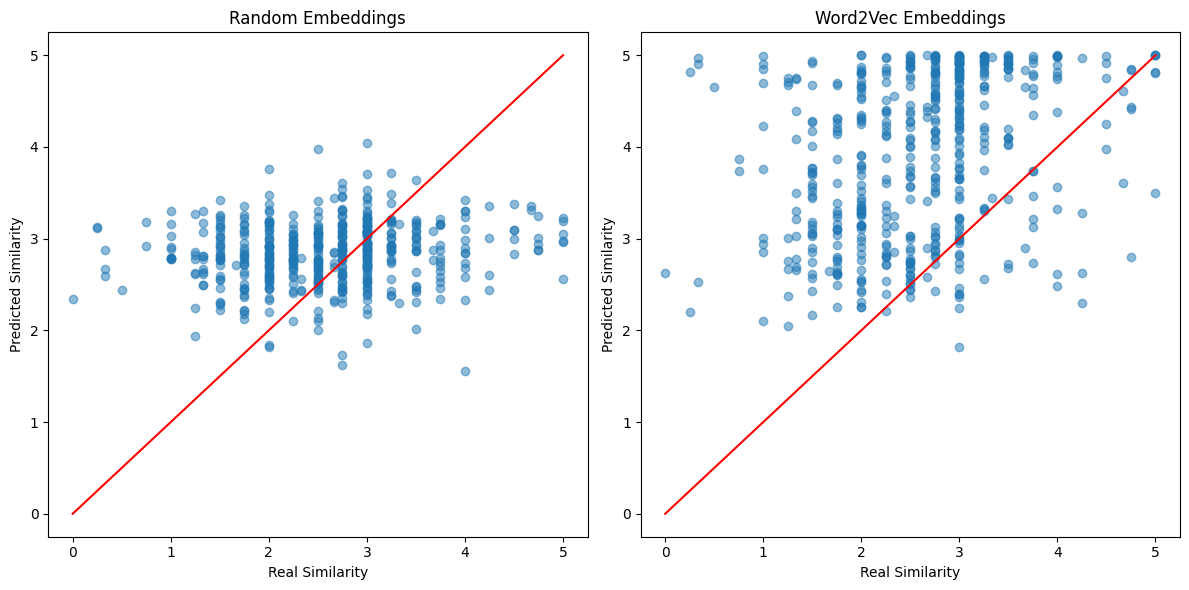

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Random Embeddings
plt.subplot(1, 2, 1)
plt.scatter(labels_test, prediccions_random, alpha=0.5)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r')
plt.xlabel('Real Similarity')
plt.ylabel('Predicted Similarity')
plt.title('Random Embeddings')

# Word2Vec Embeddings
plt.subplot(1, 2, 2)
plt.scatter(labels_test, prediccions_word2vec, alpha=0.5)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r')
plt.xlabel('Real Similarity')
plt.ylabel('Predicted Similarity')
plt.title('Word2Vec Embeddings')

plt.tight_layout()
plt.show()
